# ヘイトスピーチ検出 ベースラインチュートリアル
このNotebookはNishikaコンペティション `ヘイトスピーチ検出`のチュートリアルです。  

BERTの事前学習済みモデルに`cl-tohoku/bert-base-japanese-whole-word-masking`を使用して、簡単なベースラインを作成します。

ディレクトリの構造は以下のようになっています

```
/
├ notebook
│   └ tutotial.ipynb
└ input
   └ hate-speech-detection
      ├ train.csv
      ├ test.csv
      └ sample_submission.csv
```



In [ ]:
# ドライブをマウント
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# 自身のColab環境によってディレクトリを変更して下さい
import os
os.chdir("/content/drive/MyDrive/hate-cpt/tutorial/notebook")

In [ ]:
!nvidia-smi

Tue Sep 27 02:39:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# 必要なライブラリのインストール
!pip install -q ginza ja_ginza datasets transformers[ja]

     |████████████████████████████████| 59.1 MB 1.1 MB/s 
     |████████████████████████████████| 431 kB 58.9 MB/s 
     |████████████████████████████████| 4.9 MB 50.3 MB/s 
     |████████████████████████████████| 2.2 MB 51.7 MB/s 
     |████████████████████████████████| 120 kB 55.2 MB/s 
     |████████████████████████████████| 115 kB 55.8 MB/s 
     |████████████████████████████████| 212 kB 49.7 MB/s 
     |████████████████████████████████| 127 kB 40.6 MB/s 
     |████████████████████████████████| 6.6 MB 67.9 MB/s 
     |████████████████████████████████| 13.4 MB 55.4 MB/s 
     |████████████████████████████████| 47.4 MB 1.8 MB/s 
     |████████████████████████████████| 583 kB 14.6 MB/s 


In [ ]:
import os
import random
from dataclasses import dataclass
from pathlib import Path
from collections import Counter

import spacy
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import (
    AutoModel, AutoTokenizer, EvalPrediction, Trainer, 
    TrainingArguments, AutoModelForSequenceClassification,
)
import datasets
from datasets import Dataset

COMPETION_DATA_DIR = Path("../input/hate-speech-detection")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [ ]:
def seed_everything(seed: int):    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

SEED = 42
seed_everything(SEED)

In [ ]:
print(f"torch version: {torch.__version__}")
print(f"transfomers version: {transformers.__version__}")
print(f"datasets version: {datasets.__version__}")

torch version: 1.12.1+cu113
transfomers version: 4.22.1
datasets version: 2.5.1


# データの読み込み

In [ ]:
train_df = pd.read_csv(COMPETION_DATA_DIR/"train.csv")
test_df = pd.read_csv(COMPETION_DATA_DIR/"test.csv")
sub_df = pd.read_csv(COMPETION_DATA_DIR/"sample_submission.csv")

# EDA
最初にカラム情報、ラベル数、文字数などを確認します


In [ ]:
print("train")
display(train_df)

print("test")
display(test_df)

print("sample submission")
display(sub_df)

train


,id,source,text,label
0,80074aa43,news4vip,まともに相手されてない人との関係なんて\nそんな大事にするものか？,0
1,6378fea6b,livejupiter,最近はアヘアヘQSマンやない？ ｲｲ!(・∀・)+1-0(・Ａ・)ｲｸﾅｲ!,0
2,c535f5613,livejupiter,日本人として生まれても無能な低学歴って分かったら日本人の権利剥奪して追放すべきやろ\n甘えるな,1
3,e76638295,livejupiter,よくよく思えば川上は配布にしたらとんでもなく有能だよな\nガチャから引いたら圧倒的歓喜レベルやで,0
4,51e4036bf,newsplus,押井は原作レイプの専門家だから\n原作マンガの真意を誤解させることに関してはプロだが\nそれ...,0
...,...,...,...,...
5251,42b5f86b0,news4vip,車じゃなくてもよくない？\nケーブル網を張り巡らせてリフトみたいなのを付けるとか,0
5252,402ce15d9,livejupiter,左やぞ？\n出すなら下水流,0
5253,0739a9fcb,newsplus,日本によって、けんけんガクガクの議論を持たらされた韓国は被害者\n\n日本人がしっかり考えな...,0
5254,d496c7dc8,news4vip,ゴムボート買って、沖まで漕いで行ったら？\n魚の血を塗っておけばサメが食べてくれるよ,0


test


,id,source,text
0,96dfb36a1,livejupiter,さすがに内田が出てくるやろ\n今は上の一三塁が上げる状態じゃないから上げてないけど
1,873e93437,news4vip,それに不幸の話の方が盛り上がれる気がする(´_ゝ`)だから卑屈にもなる
2,566529295,news4vip,まとめにツイッターのオフ参加した記事とかあるけど、本当にあるんだね\n詳しく聞きたいんだけど...
3,5d2c24924,news4vip,電話での選挙活動とかいつの時代ですかね\n投票しなくてもバレるわけではなさそうだから面倒なら...
4,9bf683f4b,livejupiter,わいなんて可愛いJC見る度にヤリたいと思ってまうから大丈夫やで
...,...,...,...
3218,299ca6210,news4vip,コスプレの写真て道のど真ん中でやってるイメージあるんだけどこんな人多かったらどーするんだ？\...
3219,61fe0c124,livejupiter,言ってだめなの？\n事実やん\n知的障害者は保健所で責任持って抹殺すべきや
3220,dc393ca4e,news4vip,なにこのタイミングで変えとんねんｗｗｗ\n\n俺は穴ン中の肉びらよりも、クリトリス命なんだけ...
3221,6b48e32bc,news4vip,我々の主張は差別ではなく区別だ\n\nお前らチョンは日本人ならば誰でも殺せのレイシストだ！


sample submission


,id,label
0,96dfb36a1,0
1,873e93437,0
2,566529295,0
3,5d2c24924,0
4,9bf683f4b,0
...,...,...
3218,299ca6210,0
3219,61fe0c124,0
3220,dc393ca4e,0
3221,6b48e32bc,0


- label

In [ ]:
label_distribution = (train_df["label"].value_counts() /len(train_df))*100
label_distribution

0    94.178082
1     5.821918
Name: label, dtype: float64

ヘイトスピーチとなる陽性ラベルは約6%となっており、不均衡なデータセットになっているようです。

- source

In [ ]:
train_df["source"].value_counts() 

newsplus       1967
news4vip       1849
livejupiter    1440
Name: source, dtype: int64

In [ ]:
test_df["source"].value_counts()

newsplus       1245
news4vip       1141
livejupiter     837
Name: source, dtype: int64

- 文字数

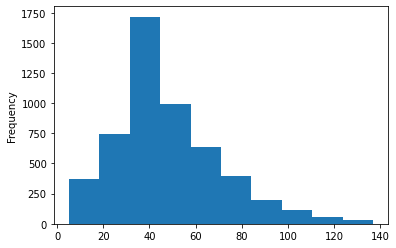

In [ ]:
train_df["text"].str.len().plot(kind="hist")

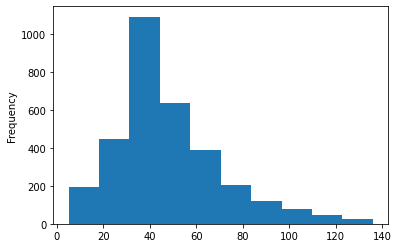

In [ ]:
test_df["text"].str.len().plot(kind="hist")

trainとtestで違いはなく、だいたい140文字以内に収まっているようです

# validationの作成
train_test_splitでvalidationセットを作成します

In [ ]:
trn_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df["label"], random_state=SEED)

## ルールベースでの精度の確認
テキストの毒性を分類を行う場合、文字一致でも十分な精度が出ることもあります。  

ここではginzaで形態素解析を行い、頻出する名詞でルールベースでの予測を行ってみます

In [ ]:
ginza_nlp = spacy.load("ja_ginza")
counter = Counter()

for text in tqdm(train_df[train_df["label"]==1]["text"]):
  # 名詞かつ文字数が2以上の単語のみカウント
  counter.update([str(t) for t in ginza_nlp(text) if (t.pos_ == "NOUN") & (len(t) > 1)])

  0%|          | 0/306 [00:00<?, ?it/s]

In [ ]:
counter.most_common(n=10)

[('日本人', 55),
 ('朝鮮人', 52),
 ('在日', 43),
 ('こと', 27),
 ('\n\n', 22),
 ('民族', 20),
 ('韓国人', 14),
 ('劣等', 12),
 ('もの', 11),
 ('価値', 9)]

頻出している中からヘイトスピーチに含まれてそうなワードをピックアップして、  
NGワードとしテキストのNGワードが含まれていればヘイトスピーチする予測を行います

In [ ]:
NG_WORDS = ["日本人", "朝鮮人", "在日", "差別", "韓国人", "劣等"]
def has_ng_words(text):
    for ng_word in NG_WORDS:
        if ng_word in text:
            return True
    return False

val_rule_preds = val_df["text"].map(has_ng_words).astype(int)

In [ ]:
f1_score(val_df["label"], val_rule_preds)

0.32432432432432434

結果は0.32でした。  
ルールベース以外の手法を使う場合、この精度を超えられるようにモデルの作成を行う必要があります。

# モデル作成
事前学習済みモデルには`cl-tohoku/bert-base-japanese-whole-word-masking`を使用します。

In [ ]:
cfg = {
    "model_name":"cl-tohoku/bert-base-japanese-whole-word-masking",
    "max_length":-1,
    "train_epoch":3,
    "lr":3e-5,
}

In [ ]:
# トークナイザとモデルの用意
tokenizer = AutoTokenizer.from_pretrained(cfg["model_name"])
model = AutoModelForSequenceClassification.from_pretrained(cfg["model_name"])

Downloading:   0%|          | 0.00/110 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/479 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/258k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialize

In [ ]:
# 訓練とテストのデータセットを結合して、トークナイズした際の単語数を調べます
whole_texts = train_df["text"].to_list() + test_df["text"].to_list()
whole_text_lengths = [len(tokenizer.encode(text)) for text in tqdm(whole_texts)]

  0%|          | 0/8479 [00:00<?, ?it/s]

In [ ]:
pd.Series(whole_text_lengths).describe(percentiles=[0.90, 0.95, 0.99])

count    8479.000000
mean       32.484255
std        14.556751
min         5.000000
50%        29.000000
90%        53.000000
95%        62.000000
99%        77.220000
max        99.000000
dtype: float64

In [ ]:
# 99％は77トークンで収まるので最大トークン数を77に設定しておきます
cfg["max_length"]=77

## Dataset
テキストをトークナイズしてデータセットを作成します

In [ ]:
class HateSpeechDataset(Dataset):
  def __init__(self, X, y=None):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    input = {
        "input_ids": self.X[index]["input_ids"],
        "attention_mask": self.X[index]["attention_mask"],
    }
    
    if self.y is not None:
      input["label"] = self.y[index]

    return input

In [ ]:
trn_X = [tokenizer(text, padding="max_length", max_length=cfg["max_length"], truncation=True) for text in tqdm(trn_df["text"])]
trn_ds = HateSpeechDataset(trn_X, trn_df["label"].tolist())

val_X = [tokenizer(text, padding="max_length", max_length=cfg["max_length"], truncation=True) for text in tqdm(val_df["text"])]
val_ds = HateSpeechDataset(val_X, val_df["label"].tolist())

test_X = [tokenizer(text, padding="max_length", max_length=cfg["max_length"], truncation=True) for text in tqdm(test_df["text"])]
test_ds = HateSpeechDataset(test_X)

  0%|          | 0/4730 [00:00<?, ?it/s]

  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/3223 [00:00<?, ?it/s]

In [ ]:
tokenizer.decode(trn_ds[0]["input_ids"])

'[CLS] ここ で 言っ てる 記者 による アク 禁 って スレ 主権 限 による アク 禁 じゃ なく て もっと 広範囲 に 影響 する もの な の? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

# トレーニング
ここでは、訓練を簡単に行うために、`Transformers`ライブラリにある`Trainer`モジュールを利用します。

`Trainer`モジュールに使用する引数等の設定は以下のリファレンスをご参考下さい。
- https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Trainer
- https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments

In [ ]:
# trainerの訓練中に評価関数を追跡できるように関数を作成しておきます
def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.argmax(preds, axis=1)
    result = f1_score(p.label_ids, preds)
    return {"f1_score":result}

In [ ]:
trainer_args = TrainingArguments(
    seed=SEED,
    output_dir=".",
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_steps=1e6, # saveのステップを大きくしてここではモデルの保存を行わないようにする
    log_level="critical",
    num_train_epochs=cfg["train_epoch"],
    learning_rate=cfg["lr"],
    per_device_train_batch_size=8,
    per_device_eval_batch_size=12,
    save_total_limit=1,
    fp16=True,
    remove_unused_columns=False,
    report_to="none"
)

In [ ]:
trainer = Trainer(
    model=model,
    args=trainer_args,
    tokenizer=tokenizer,
    train_dataset=trn_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,F1 Score
1,0.204700,0.158574,0.542373
2,0.115800,0.197708,0.611111
3,0.040600,0.215277,0.655172


TrainOutput(global_step=1776, training_loss=0.12036130879376386, metrics={'train_runtime': 180.3786, 'train_samples_per_second': 78.668, 'train_steps_per_second': 9.846, 'total_flos': 561490297691400.0, 'train_loss': 0.12036130879376386, 'epoch': 3.0})

# テストの推論

In [ ]:
test_preds = trainer.predict(test_ds)

In [ ]:
sub_df["label"] = np.argmax(test_preds.predictions, axis=1)

In [ ]:
sub_df["label"].value_counts()

0    3032
1     191
Name: label, dtype: int64

In [ ]:
sub_df.to_csv("../output/sub.csv", index=False)

In [ ]:
display(sub_df.head())

,id,label
0,96dfb36a1,0
1,873e93437,0
2,566529295,0
3,5d2c24924,0
4,9bf683f4b,0


チュートリアルを提出するとパブリックリーダーボードで0.53となります  
改善のアイデアには
- `train_test_split`から`StratifiedKFold`にしてみる
- ダウンサンプリングしてデータセットの不均衡を処理する
- 事前学習モデルを変更してみる
- ハイパーパラメーターを調整する
- データソースである[`おーぷん2ちゃんねる対話コーパス`](https://github.com/1never/open2ch-dialogue-corpus)を利用する

などが考えられます。  ぜひ、良いスコアが出るように挑戦してみて下さい